# TO DO

1. Add AZ to list.
2. Add some more info to this nb about the manifest
3. Writeup and publish

AWS NAIP:
https://aws.amazon.com/public-datasets/naip/

See naming specifications for NAIP here: 
https://lta.cr.usgs.gov/naip_full_res.html

They are based on the 7.5 by 7.5 Minute USGS quadrangle: 
https://topomaps.usgs.gov/drg/drg_name.html#hdr%209

Download the NAIP manifest from AWS and grep through the listed files for the quadrangle ID.

```shell
aws s3api get-object --bucket aws-naip --key manifest.txt --request-payer requester manifest.txt
grep "4007317" manifest.txt
```

returns a list with all files corresponding to that ID

```
ny/2013/1m/fgdc/40073/m_4007317_ne_18_1_20130622.txt
ny/2013/1m/fgdc/40073/m_4007317_nw_18_1_20130622.txt
ny/2013/1m/fgdc/40073/m_4007317_se_18_1_20130622.txt
ny/2013/1m/fgdc/40073/m_4007317_sw_18_1_20130622.txt
ny/2013/1m/rgb/40073/m_4007317_ne_18_1_20130622.tif
ny/2013/1m/rgb/40073/m_4007317_nw_18_1_20130622.tif
ny/2013/1m/rgb/40073/m_4007317_se_18_1_20130622.tif
ny/2013/1m/rgb/40073/m_4007317_sw_18_1_20130622.tif
ny/2013/1m/rgbir/40073/m_4007317_ne_18_1_20130622.tif
ny/2013/1m/rgbir/40073/m_4007317_nw_18_1_20130622.tif
ny/2013/1m/rgbir/40073/m_4007317_se_18_1_20130622.tif
ny/2013/1m/rgbir/40073/m_4007317_sw_18_1_20130622.tif
ny/2015/.5m/fgdc/40073/m_4007317_ne_18_h_20150522.txt
ny/2015/.5m/fgdc/40073/m_4007317_nw_18_h_20150522.txt
ny/2015/.5m/fgdc/40073/m_4007317_se_18_h_20150522.txt
ny/2015/.5m/fgdc/40073/m_4007317_sw_18_h_20150522.txt
ny/2015/.5m/rgb/40073/m_4007317_ne_18_h_20150522.tif
ny/2015/.5m/rgb/40073/m_4007317_nw_18_h_20150522.tif
ny/2015/.5m/rgb/40073/m_4007317_se_18_h_20150522.tif
ny/2015/.5m/rgb/40073/m_4007317_sw_18_h_20150522.tif
ny/2015/.5m/rgbir/40073/m_4007317_ne_18_h_20150522.tif
ny/2015/.5m/rgbir/40073/m_4007317_nw_18_h_20150522.tif
ny/2015/.5m/rgbir/40073/m_4007317_se_18_h_20150522.tif
ny/2015/.5m/rgbir/40073/m_4007317_sw_18_h_20150522.tif
```

Files can then be downloaded

```shell
aws s3api get-object --bucket aws-naip --key ny/2013/1m/rgb/40073/m_4007317_ne_18_1_20130622.tif --request-payer requester m_4007317_ne_18_1_20130622.tif

aws s3api get-object --bucket aws-naip --key ny/2013/1m/rgb/40073/m_4007317_sw_18_1_20130622.tif --request-payer requester m_4007317_sw_18_1_20130622.tif
```

In [15]:
import rasterio
from rasterio.mask import mask as rio_mask
from rasterio.features import rasterize
from geopy.geocoders import Nominatim
from shapely.geometry import box
from pyproj import Proj

import pprint
import os
import subprocess

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
def get_quad_id(lat, lon):
    
    ## Assume 8x8 grid
    grid_size = 8
    grid_step = 1 / grid_size 
    
    ## Find index in 1-degree block (8x8 grid)
    ## NOTE: Quad are 1-indexed
    lon_degrees = lon - int(lon)
    lat_degrees = lat - int(lat)
    col_ndx = (grid_size - 1) + int(lon_degrees / grid_step)
    row_ndx = (grid_size - 1) - int(lat_degrees / grid_step)
    ndx = 1 + np.ravel_multi_index((row_ndx , col_ndx), (grid_size, grid_size))
    
    ## Find quadrant (nw, ne, sw, se)
    lon_upper = int(lon) - grid_step * (grid_size - col_ndx - 1)
    lon_lower = int(lon) - grid_step * (grid_size - col_ndx)
    lat_upper = int(lat) + grid_step * (grid_size - row_ndx)
    lat_lower = int(lat) + grid_step * (grid_size - row_ndx - 1)
    lon_mid = (lon_upper + lon_lower) / 2
    lat_mid = (lat_upper + lat_lower) / 2
    if lat > lat_mid:
        quadrant = 'n'
    else:
        quadrant = 's'
        
    if lon > lon_mid:
        quadrant = quadrant + 'e'
    else:
        quadrant = quadrant + 'w'
    
    ## Format output string
    lat_str = str(int(lat))
    if abs(lon) < 100:
        lon_str = '0' + str(abs(int(lon)))
    else:
        lon_str = str(abs(int(lon)))
    
    return lat_str + lon_str + str(ndx) + '_' + quadrant

In [10]:
places = {
    'Empire State Building' : {'state': 'ny'},
    'Brooklyn Botanic Garden': {'state': 'ny'},
    'Calvary Cemetery': {'state': 'ny'}
}

geolocator = Nominatim()
for place, place_info in places.items():
    state = place_info['state']
    loc = geolocator.geocode(place + ' ' + state)
    lat, lon = loc.latitude, loc.longitude
    quad_id = get_quad_id(lat, lon)
    
    place_info['quad_id'] = quad_id
    place_info['coords'] = (lat, lon)

    
pprint.pprint(places)

{'Brooklyn Botanic Garden': {'coords': (40.66760805, -73.9636076711714),
                             'quad_id': '4007317_sw',
                             'state': 'ny'},
 'Calvary Cemetery': {'coords': (40.73296815, -73.9308954670053),
                      'quad_id': '4007317_ne',
                      'state': 'ny'},
 'Empire State Building': {'coords': (40.7484284, -73.9856546198733),
                           'quad_id': '4007317_nw',
                           'state': 'ny'}}


In [11]:
manifest_path = 'naip/manifest.txt'
quad_ids = [place_info['quad_id'] for place_info in places.values()]
states = [place_info['state'] for place_info in places.values()]
year = '2015'

with open(manifest_path, 'r') as manifest:
    for line in manifest:
        if '/rgb/' in line:
            man_state = line.split('/')[0]
            man_year = line.split('/')[1]
            if (
                man_state in states and 
                man_year == year and
                any([id_ in line for id_ in quad_ids])
            ):
                for place, place_info in places.items():
                    if place_info['quad_id'] in line and man_state == place_info['state']:
                        print('Found key for {}'.format(place))
                        place_info['naip_key'] = line.strip()
            
print()
pprint.pprint(places)

Found key for Calvary Cemetery
Found key for Empire State Building
Found key for Brooklyn Botanic Garden

{'Brooklyn Botanic Garden': {'coords': (40.66760805, -73.9636076711714),
                             'naip_key': 'ny/2015/.5m/rgb/40073/m_4007317_sw_18_h_20150522.tif',
                             'quad_id': '4007317_sw',
                             'state': 'ny'},
 'Calvary Cemetery': {'coords': (40.73296815, -73.9308954670053),
                      'naip_key': 'ny/2015/.5m/rgb/40073/m_4007317_ne_18_h_20150522.tif',
                      'quad_id': '4007317_ne',
                      'state': 'ny'},
 'Empire State Building': {'coords': (40.7484284, -73.9856546198733),
                           'naip_key': 'ny/2015/.5m/rgb/40073/m_4007317_nw_18_h_20150522.tif',
                           'quad_id': '4007317_nw',
                           'state': 'ny'}}


In [22]:
## Define where AWS CLI lives and where images go
aws_cli_path = '/home/carlos/anaconda3/envs/geo/bin/aws'
aws_cmd_base = aws_cli_path + ' s3api get-object --bucket aws-naip --key {} --request-payer requester {}'
img_dir = 'naip/img/'

for place, place_info in places.items():
    
    ## Create local image path
    key = place_info['naip_key']
    state = place_info['state']
    img_path = img_dir + state + '_' + key.split('/')[-1]
    place_info['img_path'] = img_path
    
    ## Download from NAIP if not already downloaded
    aws_cmd = aws_cmd_base.format(key, img_path)
    if os.path.isfile(img_path):
        print('Skipping {}'.format(key))
    else:
        print('Downloading {} with the following command:\n{}'.format(key, aws_cmd))
        subprocess.run(aws_cmd, shell = True)

print()
pprint.pprint(places)

Skipping ny/2015/.5m/rgb/40073/m_4007317_nw_18_h_20150522.tif
Skipping ny/2015/.5m/rgb/40073/m_4007317_sw_18_h_20150522.tif
Skipping ny/2015/.5m/rgb/40073/m_4007317_ne_18_h_20150522.tif

{'Brooklyn Botanic Garden': {'coords': (40.66760805, -73.9636076711714),
                             'img_path': 'naip/img/ny_m_4007317_sw_18_h_20150522.tif',
                             'naip_key': 'ny/2015/.5m/rgb/40073/m_4007317_sw_18_h_20150522.tif',
                             'quad_id': '4007317_sw',
                             'state': 'ny'},
 'Calvary Cemetery': {'coords': (40.73296815, -73.9308954670053),
                      'img_path': 'naip/img/ny_m_4007317_ne_18_h_20150522.tif',
                      'naip_key': 'ny/2015/.5m/rgb/40073/m_4007317_ne_18_h_20150522.tif',
                      'quad_id': '4007317_ne',
                      'state': 'ny'},
 'Empire State Building': {'coords': (40.7484284, -73.9856546198733),
                           'img_path': 'naip/img/ny_m_4007317_nw_1

In [19]:
def create_subset(img_path, lat, lon, mask_len = 1500, box_len = 300, box_pad = 10):
    
    with rasterio.open(img_path) as src:
    
        ## Project feature lat,lon onto image
        proj = Proj(src.crs)
        x,y = proj(lon, lat)

        ## Make mask centered at the feature
        mask_shape = box(x-mask_len/2, y-mask_len/2, x+mask_len/2, y+mask_len/2)
        mask = {'type': 'Polygon', 'coordinates': [list(mask_shape.exterior.coords)]}

        ## Extract only the data within the mask, put color channels last
        img_out, trans_out = rio_mask(src, [mask], crop = True)
        img_out = np.swapaxes(img_out, 0, 2)
        img_out = np.swapaxes(img_out, 0, 1)

        ## Create a feature box centered at the feature
        pix_per_meter = src.res[0]
        box_len_pix = int(box_len / pix_per_meter)
        box_feat = np.zeros(img_out.shape[0:2])
        top = int(box_feat.shape[0] / 2 - box_len_pix / 2)
        left = int(box_feat.shape[1] / 2 - box_len_pix / 2)
        bottom = top + box_len_pix
        right = left + box_len_pix
        box_feat[top:top+box_pad, left:right] = 1
        box_feat[bottom:bottom+box_pad, left:right] = 1
        box_feat[top:bottom, left:left+box_pad] = 1
        box_feat[top:bottom, right:right+box_pad] = 1

        ## Overlay feature box on image
        img_out[box_feat == 1] = [255, 0 ,0]
        return img_out

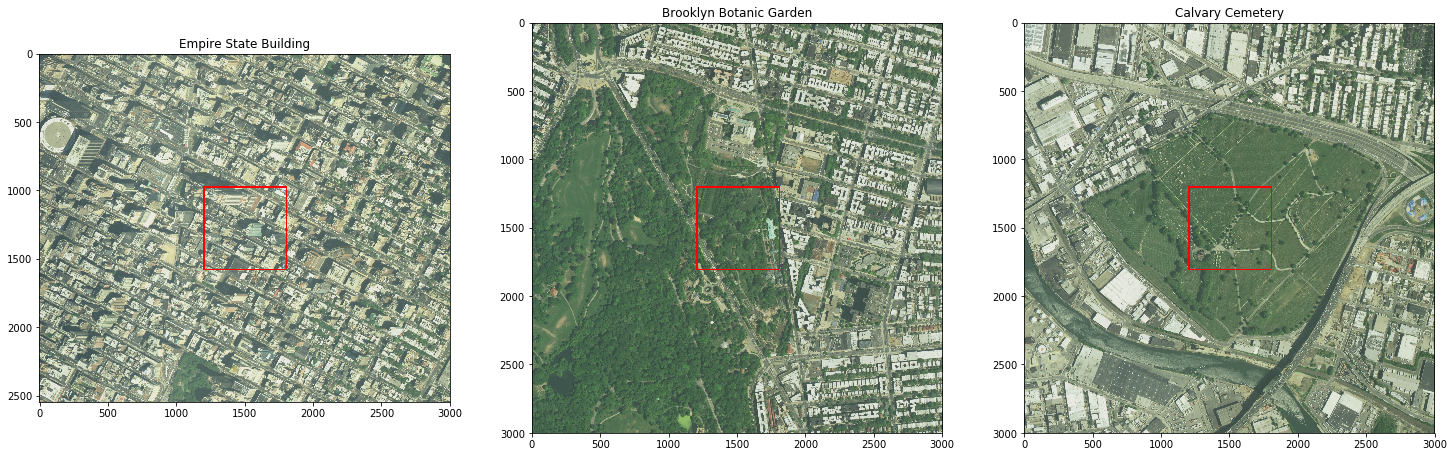

In [21]:
fig, axes = plt.subplots(1, len(places), figsize = (25, 10))

i = 0
for place, place_info in places.items():

    img_path = place_info['img_path']
    lat, lon = place_info['coords']
    img_arr = create_subset(img_path, lat, lon)
    
    ax = axes[i]
    ax.set_title(place)
    ax.imshow(img_arr)

    i = i + 1
    
fig.savefig('example_images.png')